In [64]:
#Imports + initializing tables
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import json
from pandas import DataFrame

from sympy import symbols,diff
from math import log

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

drive = pd.read_csv('./dataset/drivers.csv')
result = pd.read_csv('./dataset/results.csv')
race = pd.read_csv('./dataset/races.csv')
construct = pd.read_csv('./dataset/constructors.csv')
quali = pd.read_csv('./dataset/qualifying.csv')
laptimes = pd.read_csv('./dataset/lap_times.csv')

In [78]:
#Create new dataframe containing data with race completion times
mer1 = pd.merge(result,drive,on='driverId')
mer2 = pd.merge(mer1,race,on='raceId')
result2 = mer2[mer2.year>1995]
result2['driver'] = result2['forename'] + ' ' + result2['surname']
#result2.info()
mer2['driver'] = mer2['forename'] + ' ' + mer2['surname']
resultsTable = mer2[['resultId', 'raceId', 'driverId', 'driver','constructorId', 'grid', 'positionText', 'laps', 'year', 'name', 'round','time_x']]
resultsTable
resultsTable['year'] = resultsTable['year'].astype(str)
resultsTable['race'] = resultsTable['name'] + ' ' + resultsTable['year']
#resultsTable = resultsTable.drop(columns=['name', 'year'])
resultsTable = resultsTable.set_index('resultId')
resultsTable.to_json(r'.\venv\results.json', orient='table', index=False)
resultsTable

,raceId,driverId,driver,constructorId,grid,positionText,laps,year,name,round,time_x,race
resultId,,,,,,,,,,,,
1,18,1,Lewis Hamilton,1,1,1,58,2008,Australian Grand Prix,1,1:34:50.616,Australian Grand Prix 2008
2,18,2,Nick Heidfeld,2,5,2,58,2008,Australian Grand Prix,1,+5.478,Australian Grand Prix 2008
3,18,3,Nico Rosberg,3,7,3,58,2008,Australian Grand Prix,1,+8.163,Australian Grand Prix 2008
4,18,4,Fernando Alonso,4,11,4,58,2008,Australian Grand Prix,1,+17.181,Australian Grand Prix 2008
5,18,5,Heikki Kovalainen,1,3,5,58,2008,Australian Grand Prix,1,+18.014,Australian Grand Prix 2008
...,...,...,...,...,...,...,...,...,...,...,...,...
20119,837,786,Luigi Fagioli,51,3,2,35,1950,Belgian Grand Prix,5,+14.0,Belgian Grand Prix 1950
20128,837,774,Eugène Chaboud,154,13,R,22,1950,Belgian Grand Prix,5,\N,Belgian Grand Prix 1950
20127,837,780,Toni Branca,105,11,10,29,1950,Belgian Grand Prix,5,\N,Belgian Grand Prix 1950


In [59]:
raceNames = resultsTable.race.unique()
raceYears = resultsTable.year.unique()

In [204]:
for race in raceNames:
    filename = race + '.json'
    raceJson = resultsTable[resultsTable.race == race].reset_index().to_json(filename, orient='table', index=True)

array(['Australian Grand Prix 2008', 'Malaysian Grand Prix 2008',
       'Bahrain Grand Prix 2008', ..., 'Indianapolis 500 1950',
       'British Grand Prix 1950', 'Belgian Grand Prix 1950'], dtype=object)

In [65]:
predResults = result2[['resultId', 'raceId', 'driverId', 'constructorId', 'number_x', 'position','positionOrder', 'points', 'laps', 'milliseconds','circuitId', 'year', 'driver']]
finishes = predResults.loc[:9637, ['raceId', 'driverId','laps','positionOrder', 'milliseconds']]
laps = laptimes.loc[:487314, ['raceId', 'driverId', 'milliseconds']]

In [66]:
laps['milliseconds'] = pd.to_numeric(laps['milliseconds'], errors='coerce')
#Converting column from object to float by replacing \n entries with nan
finishes['milliseconds'] = pd.to_numeric(finishes['milliseconds'], errors='coerce')
finishes.dropna(axis=0, subset=['milliseconds'], inplace= True)
finishes.reset_index(drop=True)

,raceId,driverId,laps,positionOrder,milliseconds
0,18,1,58,1,5690616.0
1,18,2,58,2,5696094.0
2,18,3,58,3,5698779.0
3,18,4,58,4,5707797.0
4,18,5,58,5,5708630.0
...,...,...,...,...,...
4009,236,55,44,4,5314250.0
4010,236,57,44,3,5310835.0
4011,236,71,44,5,5324304.0
4012,236,77,44,6,5325021.0


In [203]:
finishes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4014 entries, 0 to 9633
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   raceId        4014 non-null   int64  
 1   driverId      4014 non-null   int64  
 2   laps          4014 non-null   int64  
 3   milliseconds  4014 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 156.8 KB


In [186]:
#Get appropriate variables then split them
X = DataFrame(finishes, columns=['laps'])
Y = DataFrame(finishes, columns=['milliseconds'])
Y.dropna()
Y['milliseconds']
Y['milliseconds'].astype(int)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)
x_train['laps'].max()
#Clean times up in order to use in visualisations + model, \n must be replaced or removed

87

In [187]:
#Create Linear Regression Model (can't be done with NaN)
#Divide intercept+ coef by 60000 to get time in minutes 
regr = LinearRegression()
regr.fit(x_train, y_train)
print('Intercept:', regr.intercept_[0] / 60000)
print('Coefficent:', regr.coef_[0][0] / 60000)
intercept_mins = regr.intercept_[0] / 60000
coef_mins = regr.coef_[0] /60000
lin_predicted = regr.predict(y_test)
lin_score = round(regr.score(x_train,y_train)*100, 2)
lin_score_test = round(regr.score(x_test, y_test) * 100, 2)
print('Score: ', lin_score)
print('Score test: ', lin_score_test)
print('Mean Squared Error: ', mean_squared_error(x_test, lin_predicted))
lin_predicted

model=DataFrame(list(zip(regr.intercept_, regr.coef_)), columns=['intercepts', 'coefficents'])

model.to_json(r'.\venv\modelTable.json', orient='table', index=True)
model

Intercept: 67.97405719258349
Coefficent: 0.47853664732169493
Score:  7.34
Score test:  7.72
Mean Squared Error:  2.881414436951602e+22


,intercepts,coefficents
0,4.078443e+06,[28712.198839301695]


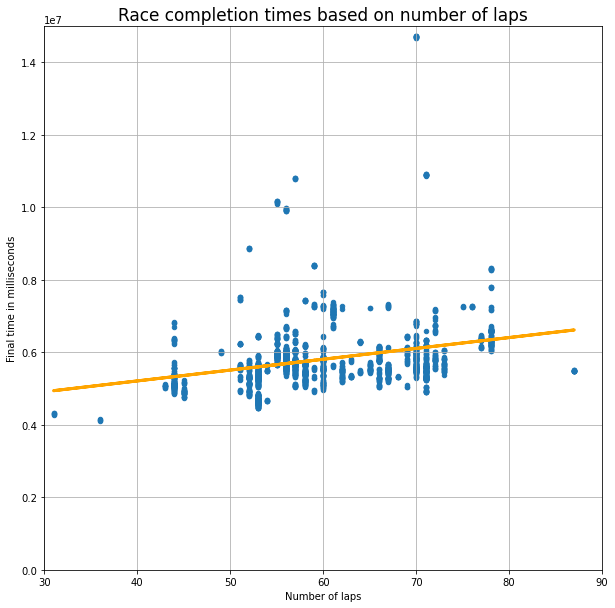

In [72]:
plt.figure(figsize=[10,10])
plt.xlim(30, 90)
plt.ylim(0, 15000000)
plt.title('Race completion times based on number of laps', fontsize=17)
plt.scatter(x_train, y_train, s=20)
plt.plot(x_train, regr.predict(x_train), color='orange', linewidth=3)
plt.xlabel('Number of laps')
plt.ylabel('Final time in milliseconds')
plt.grid()
plt.savefig('finalTimeOverLaps.png')
plt.show()

In [6]:
#filename = 'model1.pkl'
#pickle.dump(regr, (filename,'wb'))

#Attempt 2 at Linear Regression, requires better fitting
merged = mer2.drop(columns=['url_x', 'url_y', 'nationality', 'dob', 'code'])
merged['driver'] = merged['forename'] + ' ' + merged['surname']
merged = merged.drop(columns=['forename', 'surname'])
quali2020= quali[quali.raceId >= 1031]
results2020 = result[result.raceId >= 1031]
#bahrain2020 = merged[merged.raceId == 1045]
#abudhabi2020 = merged[merged.raceId == 1047]
#quali_bahrain2020 = quali[quali.raceId == 1045]
#quali_abudhabi2020 = quali[quali.raceId == 1047]
#bahrain2020 = bahrain2020.sort_values(by=['positionOrder'])
#abudhabi2020 = abudhabi2020.sort_values(by=['positionOrder'])
quali2020
raceQuali = pd.merge(results2020, quali2020, on=['raceId', 'driverId', 'constructorId'])
#race_Quali = pd.merge(merged['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder', 'positionText'],
#                      quali2020['position'], left_on=['raceId', 'driverid'], right_on=['raceId', 'driverid'])
#raceQuali = raceQuali.fillna(0)
raceQuali = raceQuali.rename(columns={"position_y": "startGrid"})
#raceQuali['milliseconds'] = np.where(raceQuali['milliseconds'] == '\\N','0', raceQuali['milliseconds'])
raceQuali['milliseconds'] = pd.to_numeric(raceQuali['milliseconds'], errors='coerce')
raceQuali.dropna(axis=0, subset=['milliseconds'], inplace= True)
raceQuali['milliseconds'] = raceQuali['milliseconds'].astype(int)
raceQuali['finish'] = 0
merged.info()
merged
#raceQuali.drop['statusId', 'number_x', 'number_y']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24960 entries, 0 to 24959
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         24960 non-null  int64  
 1   raceId           24960 non-null  int64  
 2   driverId         24960 non-null  int64  
 3   constructorId    24960 non-null  int64  
 4   number_x         24960 non-null  object 
 5   grid             24960 non-null  int64  
 6   position         24960 non-null  object 
 7   positionText     24960 non-null  object 
 8   positionOrder    24960 non-null  int64  
 9   points           24960 non-null  float64
 10  laps             24960 non-null  int64  
 11  time_x           24960 non-null  object 
 12  milliseconds     24960 non-null  object 
 13  fastestLap       24960 non-null  object 
 14  rank             24960 non-null  object 
 15  fastestLapTime   24960 non-null  object 
 16  fastestLapSpeed  24960 non-null  object 
 17  statusId    

,resultId,raceId,driverId,constructorId,number_x,grid,position,positionText,positionOrder,points,...,statusId,driverRef,number_y,year,round,circuitId,name,date,time_y,driver
0,1,18,1,1,22,1,1,1,1,10.0,...,1,hamilton,44,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,Lewis Hamilton
1,2,18,2,2,3,5,2,2,2,8.0,...,1,heidfeld,\N,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,Nick Heidfeld
2,3,18,3,3,7,7,3,3,3,6.0,...,1,rosberg,6,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,Nico Rosberg
3,4,18,4,4,5,11,4,4,4,5.0,...,1,alonso,14,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,Fernando Alonso
4,5,18,5,1,23,3,5,5,5,4.0,...,1,kovalainen,\N,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,Heikki Kovalainen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24955,20119,837,786,51,12,3,2,2,2,6.0,...,1,fagioli,\N,1950,5,13,Belgian Grand Prix,1950-06-18,\N,Luigi Fagioli
24956,20128,837,774,154,20,13,\N,R,11,0.0,...,108,chaboud,\N,1950,5,13,Belgian Grand Prix,1950-06-18,\N,Eugène Chaboud
24957,20127,837,780,105,30,11,10,10,10,0.0,...,16,branca,\N,1950,5,13,Belgian Grand Prix,1950-06-18,\N,Toni Branca
24958,20126,837,785,126,26,12,9,9,9,0.0,...,15,crossley,\N,1950,5,13,Belgian Grand Prix,1950-06-18,\N,Geoff Crossley


In [197]:
#mod_x = raceQuali[['laps', 'startGrid']]
#mod_y = raceQuali[['milliseconds', 'positionOrder']]
mod_x = raceQuali[['startGrid']]
mod_y = raceQuali[['milliseconds']]
mod_x = mod_x.reset_index(drop=True)
mod_y = mod_y.reset_index(drop=True)
X_train, X_test, Y_train, Y_test = train_test_split(mod_x, mod_y, test_size = 0.3)
mod_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   startGrid  191 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


In [200]:
linRegr = LinearRegression()
linRegr = linRegr.fit(X_train, Y_train)
print('Intercept:', linRegr.intercept_[0])
print('Coefficent:', linRegr.coef_[0][0])
print('Score: ', linRegr.score(X_train, Y_train))

Intercept: 1.9023337238675078
Coefficent: 0.5669929771571369
Score:  0.546375673652571


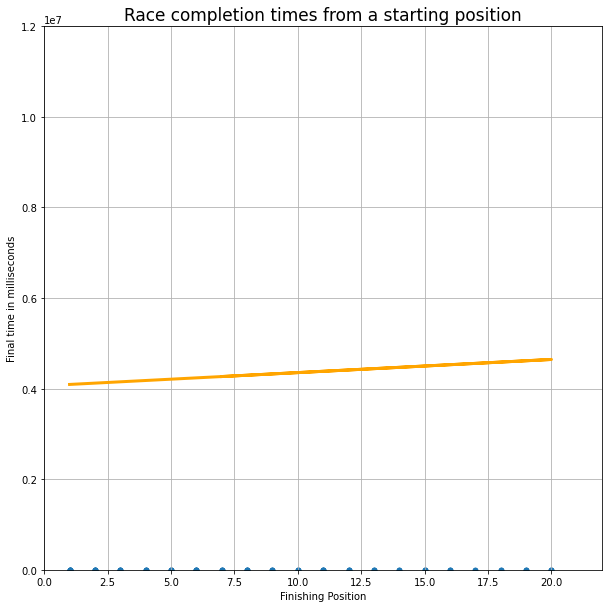

In [201]:
plt.figure(figsize=[10,10])
plt.xlim(0, 22)
plt.ylim(0, 12000000)
plt.title('Race completion times from a starting position', fontsize=17)
plt.scatter(X_train, Y_train, s=20)
plt.plot(X_train, regr.predict(X_train), color='orange', linewidth=3)
plt.xlabel('Finishing Position')
plt.ylabel('Final time in milliseconds')
plt.grid()
plt.show()

In [55]:
lastRace2020 =result2[result2.raceId == 1047]
lastRace2020 = pd.merge(lastRace2020,construct,on='constructorId')
lastRace = lastRace2020[['positionOrder', 'driver', 'name_y',  'points', 'time_x']]
lastRace = lastRace.sort_values(by=['positionOrder', 'points'], ascending=True, ignore_index=True)
lastRace = lastRace.rename_axis('key', axis=0)
lastRace
#result = lastRace.to_json(orient='table')
#parsed = json.loads(result)
lastRace.to_json(r'.\lastRaceTable.json', orient='table', index=True)
#lastRace.to_dict(orient='records')

In [198]:
#Attempt 3 - Multiple Linear Regression
data = result2.copy()
data['driver'] = data['forename'] + ' ' + data['surname']
data = data.drop(columns=['url_x', 'nationality', 'url_y', 'dob', 'code', 'statusId', 'driverRef', 'position', 'positionText', 'forename', 'surname', 'time_x', 'time_y', 'number_y', 'fastestLapTime', 'name', 'date'])
#data.number_y
data['milliseconds'] = pd.to_numeric(data['milliseconds'], errors='coerce')
data['fastestLapSpeed'] = pd.to_numeric(data['fastestLapSpeed'], errors='coerce')
data['rank'] = pd.to_numeric(data['rank'], errors='coerce')
data['fastestLap'] = pd.to_numeric(data['fastestLap'], errors='coerce')
#data['fastestLapTime'] = pd.to_numeric(data['fastestLapTime'], errors='coerce')
data.milliseconds = data.milliseconds.fillna(0)
data.fastestLapSpeed = data.fastestLapSpeed.fillna(0)
data['rank'] = data['rank'].fillna(0)
data.fastestLap = data.fastestLap.fillna(0)
#data.dropna(axis=0, subset=['milliseconds'], inplace= True)
#quali2020
data['podium'] = 0
result2['podium'] = 0


data2 = data[['circuitId', 'round', 'driver', 'grid', 'milliseconds','points', 'podium']]
data.drop_duplicates(inplace=True)
data

,resultId,raceId,driverId,constructorId,number_x,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapSpeed,year,round,circuitId,driver,podium
0,1,18,1,1,22,1,1,10.0,58,5690616.0,39.0,2.0,218.300,2008,1,1,Lewis Hamilton,0
1,2,18,2,2,3,5,2,8.0,58,5696094.0,41.0,3.0,217.586,2008,1,1,Nick Heidfeld,0
2,3,18,3,3,7,7,3,6.0,58,5698779.0,41.0,5.0,216.719,2008,1,1,Nico Rosberg,0
3,4,18,4,4,5,11,4,5.0,58,5707797.0,58.0,7.0,215.464,2008,1,1,Fernando Alonso,0
4,5,18,5,1,23,3,5,4.0,58,5708630.0,43.0,1.0,218.385,2008,1,1,Heikki Kovalainen,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9692,4704,239,77,22,4,4,4,3.0,52,5580317.0,0.0,0.0,0.000,1996,16,22,Gerhard Berger,0
9693,4715,239,79,25,18,14,15,0.0,37,0.0,0.0,0.0,0.000,1996,16,22,Ukyo Katayama,0
9694,4712,239,83,18,20,18,12,0.0,50,0.0,0.0,0.0,0.000,1996,16,22,Pedro Lamy,0
9695,4705,239,84,17,12,10,5,2.0,52,5620911.0,0.0,0.0,0.000,1996,16,22,Martin Brundle,0


In [197]:
#For loop used to assign podium with value of 1 where a driver finishes in 3rd or higher
for n in range(len(data.podium)):
    if(data.loc[n].at['positionOrder'] <= 3):
        data.at[n, 'podium'] = 1
    else:
        data.at[n, 'podium'] = 0

In [191]:
dfScaler = StandardScaler()
modelData = data.copy()
score = 0
lRegr = LinearRegression(fit_intercept= True, normalize= False)
trainingData = modelData[modelData.year < 2020]
x_train = trainingData.drop(['driver', 'podium'], axis=1)
y_train = trainingData.podium
x_train = pd.DataFrame(dfScaler.fit_transform(x_train), columns = x_train.columns)
lRegr.fit(x_train, y_train)
train = lRegr.predict(x_train)
results = trainingData['driver']
predRows = []
#Returns 1 podium for each race
for track in modelData[modelData.year == 2020]['round'].unique():
    testData = modelData[(modelData.year == 2020)& (modelData['round'] == track)]
    predDrivers= modelData[(modelData.year == 2020)& (modelData['round'] == track)]['driver']
    predDrivers = predDrivers.reset_index(drop=True)
    #Podium and driver dropped to accomodate y_test and to ensure there no strings respectively
    x_test = testData.drop(['podium', 'driver'], axis = 1)
    y_test = testData['podium']
    #Data is normalized for better accuracy
    x_test = pd.DataFrame(dfScaler.transform(x_test), columns=x_test.columns)
    
    #Each column of resulting prediction dataframe is assigned
    predictions = pd.DataFrame(lRegr.predict(x_test), columns=['results'])
    predictions['podium'] = y_test.reset_index(drop=True)
    predictions['actual'] = predictions.podium.map(lambda x:1 if x ==1 else 0)
    predictions['prediction'] = predictions.index
    predictions['prediction'] = predictions.prediction.map(lambda x: 1 if x == 0 else 0)
    #Driver column is added to ensure that data is more legible when sent to front end
    predictions['driver'] = pd.Series(predDrivers, index=predictions.index)
    #Inner for loop to add each prediction result to a list which is converted to dataframe outside of the final result
    for row in range(len(predictions.index)):
        predDict = {}
        predDict.update(predictions.loc[row])
        predRows.append(predDict)
    score += precision_score(predictions.actual, predictions.prediction)
    
    
#Final score of model is calculated here, divided by number of rounds to determine its accuracy across a season
mScore = score / data[data.year == 2020]['round'].unique().max()

allPred = pd.DataFrame(predRows, columns=['results', 'podium', 'actual', 'prediction','driver'])
#For loop used to create dataframe which will contain predictions for every race in 2020 season
#I defined outside of for loop for stability
i = 0
for driver in allPred['driver'].unique():
    driverPred = allPred[allPred['driver'].str.contains(driver)]
    totalRes = driverPred['results'].sum()
    totalPod = driverPred['podium'].sum()
    totalAct = driverPred['actual'].sum()
    totalPred = driverPred['prediction'].sum()
    curDriver = driver
    finalPred.at[i,'results'] = totalRes
    finalPred.at[i,'podium'] = totalPod
    finalPred.at[i,'actual'] = totalAct
    finalPred.at[i,'prediction'] = totalPred
    finalPred.at[i,'driver'] = curDriver
    i += 1
    
#First 20 rows of finalPred used as entries after this contain no prediction results
combinedPred = finalPred.iloc[:20]
#Outputted to json in form that can be sent to and read by front end, may change for inserting into database
combinedPred.to_json(r'.\venv\finalPredTable.json', orient='table', index=True)
combinedPred
print('Model score: ' + mScore.astype(str))
print('Mean Squared Error: ', mean_squared_error(y_test, lRegr.predict(x_test)))

Model score: 0.8235294117647058
Mean Squared Error:  0.04487284089771469


In [201]:
#plt.figure(figsize=[10,10])
#plt.xlim(0, 22)
#plt.ylim(0, 12000000)
#plt.title('Race completion times from a starting position', fontsize=17)
#plt.scatter(predictions.actual, predictions.prediction, s=20)
##plt.plot(x_train, lRegr.predict(x_train), color='orange', linewidth=3)
#plt.xlabel('Finishing Position')
#plt.ylabel('Final time in milliseconds')
#plt.grid()
#plt.show()